<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Описание данных**

Данные находятся в файле `/datasets/Churn.csv` (англ. «отток клиентов»).

***Признаки***

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

***Целевой признак***

- Exited — факт ухода клиента

## Подготовка данных

Загрузим и подготовим данные

In [1]:
# Импортируем базы данных, которые пригодятся в нашем исследование
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from copy import deepcopy
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import shuffle

In [2]:
# прочитаем файл 'Churn' из папки /datasets/ и сохраним результат в датафрейме 'churn'
churn = pd.read_csv('/datasets/Churn.csv')

In [3]:
# Посмотрим основную информацию датафрейма 
# и статистические данные, которые дают представление о распределение значений (округлив до сотых)
display(churn.head(), churn.info(), churn.describe().round(2))
# Посмотрим кол-во дубликатов
print('Кол-во дубликатов:', churn.duplicated().sum(), '\n')
# Проверим кол-во пропусков в столбцах датафрейма
print('Кол-во пропусков в столбцах\n', churn.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


None

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00,10000.00,10000.00,10000.00,9091.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.0
mean,5000.50,15690940.57,650.53,38.92,5.00,76485.89,1.53,0.71,0.52,100090.24,0.2
std,2886.90,71936.19,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.4
min,1.00,15565701.00,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.0
25%,2500.75,15628528.25,584.00,32.00,2.00,0.00,1.00,0.00,0.00,51002.11,0.0
50%,5000.50,15690738.00,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.92,0.0
75%,7500.25,15753233.75,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.0
max,10000.00,15815690.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.0


Кол-во дубликатов: 0 

Кол-во пропусков в столбцах
 RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64


В нашем датафрейме 10 тысяч строк, явные дубликаты отсутсвуют, есть пропущенные значения в столбце "Tenure", названия самих столбцов приведем к нижнему регистру. Типы данных: столбцы "Фамилия", "Страна проживания", "Пол" - строки; "Сколько лет человек является клиентом банка", "Баланс на счёте", "Предполагаемая зарплата" - числа с плавающей точкой (десятичне), остальные столбцы - целочисленные. Возможно "Tenure" стоит так же привести к целочисленному, проверим. У 25% клиентов отсутсвует баланс на счете. Возраст клиентов по нашим данным от 18 до 92 лет. Минимальная предполагаемая зарплата 11,58, при средней почти равной медиане? Техническая ошибка, неправильно заполненные данные? Нужно разбираться. Столбцы "индекс строки в данных" и "уникальный идентификатор клиента" - с уникальными значениями, повторяющихся строк не должно быть.

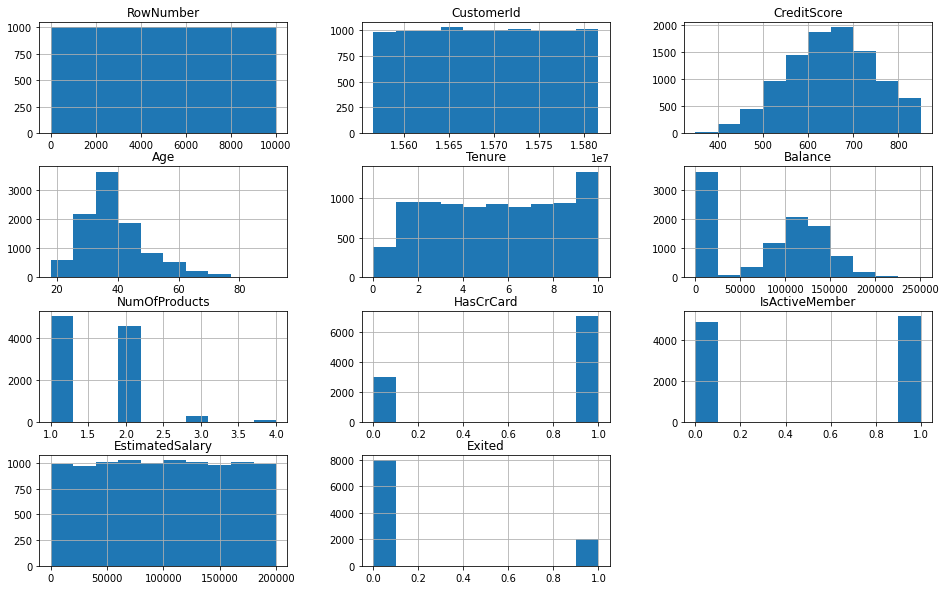

In [5]:
# построим общую гистограмму для всех столбцов таблицы
churn.hist(figsize=(16, 10))
plt.show()

По гистограммам можно сказать:
- У столбца "индекс строки в данных" - ровная полка, а вот у "уникальный идентификатор клиента" нет, есть повторяющиеся значения?
- Кредитный рейтинг - средняя близка к медиане. Основной диапазон клиентов с рейтингом от 500 до 800. Распределение можно назвать нормальным.
- Возраст - Большая часть клиентов в возрасте от 25 до 45. пик приходится на 35-40 лет. А вот возраст 92 года выглядит как выброс.
- Tenure - в целом распределение равномерное для клиентов от года до 9 лет. Преобладающее кол-во "стареньких" клиентов, те, кто в банке 10 лет.
- Balance - гистограмма подтверждает, что у большинства клиентов средст на счете нет - те, куто покинул банк? У остальных клиентов основной диапазон распределен от 75 до 175 тысяч.
- NumOfProducts - в целом клиенты распределились между собой на тех, кто пользуется 1 банковским продуктом или 2. Незначительная часть использует 3 или 4 продукта.
- HasCrCard - примерно в 2,5 раза больше тех, у кого имеется кредитная карта.
- IsActiveMember - равномерное распределние между активным и неактивным клиентами.
- EstimatedSalary - равномерное распределение между между всеми клиентами. Банк выделил 10 равномерных диапазонов ожидаемых зарплат, в каждом по +- 1 тысяча клиентов (итого 10 тыс клиентов).
- Exited - примерно 20% процентов, тех кто ушел, и 80% кто остался

**Создадим копию датафрейма**

In [6]:
# Для удобства работать будем в копии базы, что бы всегда можно что-то сравнить с оригиналом
# копию базы назовем 'data'
data = deepcopy(churn)
data.sample(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
832,833,15797964,Cameron,732,Germany,Female,29,1.0,154333.82,1,1,1,138527.56,0
7126,7127,15698271,Graham,523,France,Female,26,4.0,0.00,2,1,0,185488.81,0
2897,2898,15664150,Holland,528,Germany,Female,29,NaN,170214.23,2,1,0,49284.00,0


**Заменим названия столбцов (приведем к нижнему регистру и разделим подчеркиванием)**

In [7]:
# выведем на экран названия столбцов
churn.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [8]:
# разделяем наименование
data = data.rename(
    columns = {'RowNumber': 'Row_Number', 
    'CustomerId': 'Customer_Id', 
    'CreditScore': 'Credit_Score', 
    'NumOfProducts': 'Num_Of_Products',
    'HasCrCard': 'Has_Cr_Card',
    'IsActiveMember': 'Is_Active_Member',
    'EstimatedSalary': 'Estimated_Salary'}
) 

In [9]:
# Приведем названия столбцов к нижнему регистру
data.columns = map(str.lower, data.columns)
# смотрим
data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

**Преобразуем данные в нужные типы и обработуем пропуски при необходимости**

In [10]:
# Посмотрим срез датафрейма по количеству пропущенных значений в tenure, но с указанным возрастом клиента
data.loc[data['tenure'].isna() == True, 'age'].value_counts()

36    55
38    53
40    49
31    45
32    44
37    43
35    43
33    39
39    36
34    35
29    35
43    32
30    31
41    28
28    26
44    24
42    24
45    22
26    18
49    14
50    14
55    14
47    14
27    14
46    13
25    12
48    12
52    10
54     9
51     8
56     8
53     8
23     7
24     7
59     6
21     5
60     5
22     4
58     4
61     4
62     4
63     4
20     3
75     2
66     2
74     2
71     2
68     2
18     2
65     2
64     2
57     2
67     1
70     1
72     1
19     1
78     1
92     1
Name: age, dtype: int64

In [11]:
# Для понимания дальнейшей обработки посмотрим на распределение tenure к примеру на возрасте 18 лет
data.loc[(data['age'] == 18)]

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
746,747,15787619,Hsieh,844,France,Male,18,2.0,160980.03,1,0,0,145936.28,0
1619,1620,15770309,McDonald,656,France,Male,18,10.0,151762.74,1,0,1,127014.32,0
1678,1679,15569178,Kharlamov,570,France,Female,18,NaN,82767.42,1,1,0,71811.90,0
2021,2022,15795519,Vasiliev,716,Germany,Female,18,3.0,128743.80,1,0,0,197322.13,0
2136,2137,15621893,Bellucci,727,France,Male,18,4.0,133550.67,1,1,1,46941.41,0
2141,2142,15758372,Wallace,674,France,Male,18,7.0,0.00,2,1,1,55753.12,1
3330,3331,15657439,Chao,738,France,Male,18,4.0,0.00,2,1,1,47799.15,0
3512,3513,15657779,Boylan,806,Spain,Male,18,3.0,0.00,2,1,1,86994.54,0
3517,3518,15757821,Burgess,771,Spain,Male,18,1.0,0.00,2,0,0,41542.95,0
3686,3687,15665327,Cattaneo,706,France,Male,18,2.0,176139.50,2,1,0,129654.22,0


In [12]:
# Предположим, что сколько лет человек является клиентом банка зависит от его возраста.
# Тогда заполним пропуски в столбце "tenure" медианнымы значениями этого столбца для каждого возраста. 
# Выбираем медиану из-за того, что она дает нам представление о том, 
#     где находится «центр» набора данных. Это также дает нам представление о «типичном» значении в данном наборе данных,
#    т.к. челвоек в те же 18 лет может быть клиентом банка как 1 год, так и 10 лет.
for age_value in data['age'].unique():
    data.loc[(data['age'] == age_value) & (data['tenure'].isna()), 
             'tenure'] = data.loc[(data['age'] == age_value), 'tenure'].median()

# проверим пропуски
data['tenure'].isna().sum()

0

In [13]:
# Заменим типы данных на целочисленый
data['tenure'] = data['tenure'].astype(int)

# посмотрим за замену
data.info()
data.loc[(data['age'] == 18)].head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  int64  
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
746,747,15787619,Hsieh,844,France,Male,18,2,160980.03,1,0,0,145936.28,0
1619,1620,15770309,McDonald,656,France,Male,18,10,151762.74,1,0,1,127014.32,0
1678,1679,15569178,Kharlamov,570,France,Female,18,4,82767.42,1,1,0,71811.90,0
2021,2022,15795519,Vasiliev,716,Germany,Female,18,3,128743.80,1,0,0,197322.13,0
2136,2137,15621893,Bellucci,727,France,Male,18,4,133550.67,1,1,1,46941.41,0


In [14]:
# Проверим уникальный идентификатор клиента на повторяющиеся значения
data['customer_id'].value_counts(ascending=False, dropna=False)

15695872    1
15801062    1
15682268    1
15647453    1
15684319    1
           ..
15629677    1
15773039    1
15766896    1
15719793    1
15812607    1
Name: customer_id, Length: 10000, dtype: int64

Повторяющихся значений нет

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: credit_score, dtype: float64


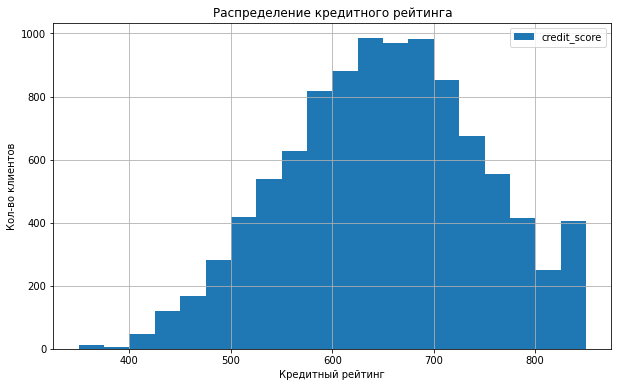

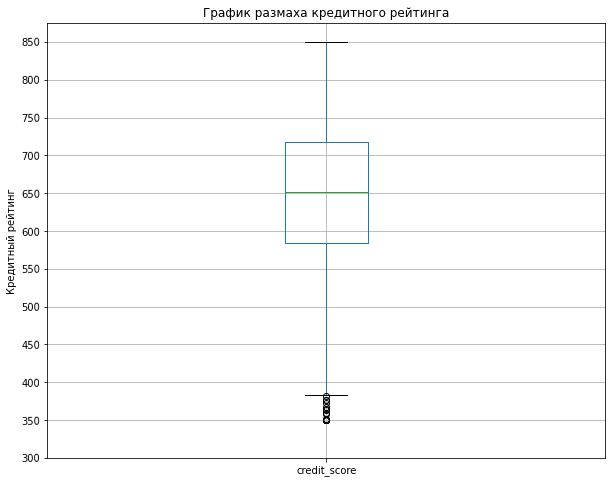

In [15]:
# Посмотрим на распределение кредитного рейтинга

#  Посмотрим на статистические данные столбца, которые дают представление о распределение значений
print(data['credit_score'].describe())

# гистограмма
data.plot(kind='hist', y='credit_score', bins=20, grid=True, figsize=(10, 6))
plt.title('Распределение кредитного рейтинга')
plt.xlabel('Кредитный рейтинг')
plt.ylabel('Кол-во клиентов')
plt.show()

# график размаха
data.boxplot(column = 'credit_score', figsize=(10,8))
plt.title('График размаха кредитного рейтинга')
plt.yticks(ticks=np.arange(300,900,50), rotation=1)
plt.ylabel('Кредитный рейтинг')
plt.show()

Самая большая часть клиентов с рейтингом от 580 до 720. Основное кол-во клиентов в и диапозоне от 480 до 850. Заметно увелечение клиентов с максимальным рейтингом. По графику размаха видим, что присутсвуют редкие значения, которые меньше 380, можно считать их выбросами.

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64


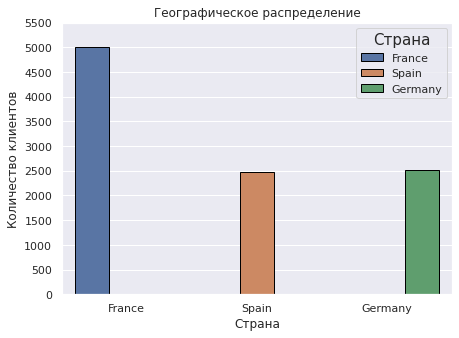

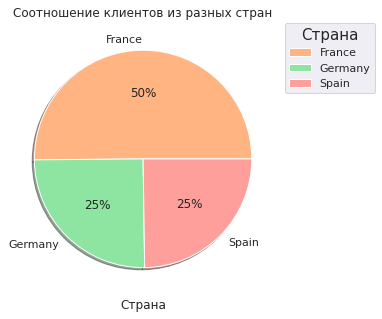

In [16]:
# Посмотрим на географическое распределение


# Посмотрим на кол-во стран
print(data['geography'].value_counts())

# Посмотрим на столбчатый график 
sns.set(rc={'figure.figsize':(7,5)})
sns.countplot(data=data, x='geography', ec='black', hue='geography')
plt.title('Географическое распределение')
plt.xlabel('Страна')
plt.ylabel('Количество клиентов')
plt.yticks(ticks=np.arange(0,5501,500))
legend = plt.legend(title = "Страна", title_fontsize = 15)
plt.show()

# Посмотрим на круговую диаграмму
colors = sns.color_palette('pastel')[1:5]
data.groupby(['geography']).count() .plot(kind='pie', y='customer_id',
  autopct='%1.0f%%', colors=colors, shadow=True)
plt.title('Соотношение клиентов из разных стран')
plt.xlabel('Страна')
plt.ylabel('')
legend = plt.legend(title = "Страна", title_fontsize = 15, bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()


50% клиентов у нас из Франции (5014 человека), по 25% из Германии и Испании (2509 и 2477 клиента соответсвенно). Можно сказать, что выборка с минимальным кол-вом значений отсутсвует.

Male      5457
Female    4543
Name: gender, dtype: int64


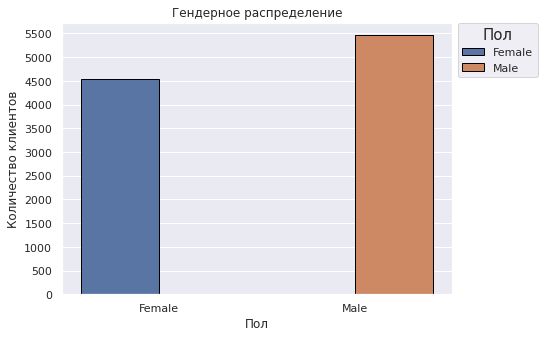

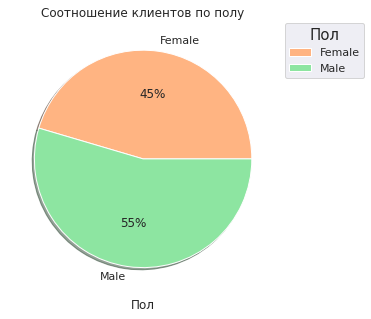

In [17]:
# Распределение по гендерной принадлежности


# Посмотрим на кол-во мужчин и женщин
print(data['gender'].value_counts())

# Посмотрим на столбчатый график 
sns.set(rc={'figure.figsize':(7,5)})
sns.countplot(data=data, x='gender', ec='black', hue='gender')
plt.title('Гендерное распределение')
plt.xlabel('Пол')
plt.ylabel('Количество клиентов')
plt.yticks(ticks=np.arange(0,5501,500))
legend = plt.legend(title = "Пол", title_fontsize = 15, bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

# Посмотрим на круговую диаграмму
colors = sns.color_palette('pastel')[1:5]
data.groupby(['gender']).count() .plot(kind='pie', y='customer_id',
  autopct='%1.0f%%', colors=colors, shadow=True)
plt.title('Соотношение клиентов по полу')
plt.xlabel('Пол')
plt.ylabel('')
legend = plt.legend(title = "Пол", title_fontsize = 15, bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()


Клиентов-мужчин на 914 человек больше, чем клиентов-женщин (5457 против 4543 человека соответсвенно), что составляет 55% об общего числа банковских пользователей. Выборки плюс минус равномерны.

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64


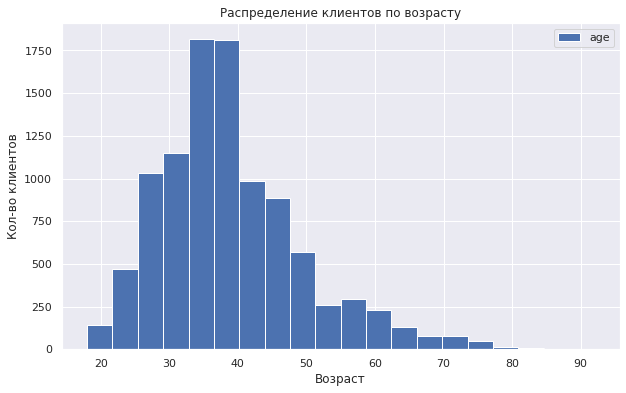

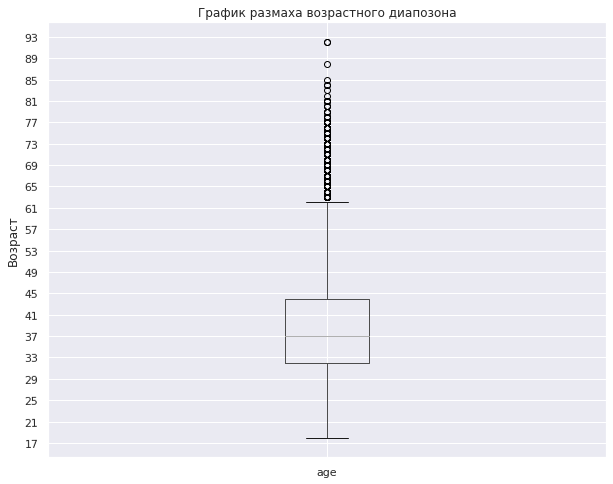

In [18]:
# Возраст

#  Посмотрим на статистические данные столбца, которые дают представление о распределение значений
print(data['age'].describe())

# гистограмма
data.plot(kind='hist', y='age', bins=20, grid=True, figsize=(10, 6))
plt.title('Распределение клиентов по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Кол-во клиентов')
plt.show()

# график размаха
data.boxplot(column = 'age', figsize=(10,8))
plt.title('График размаха возрастного диапозона')
plt.yticks(ticks=np.arange(17,94,4), rotation=1)
plt.ylabel('Возраст')
plt.show()

Основная часть клиентов в возрасте от 18 до 62 лет. Преобладают 33-40 летние. Клиенты старше 62 лет - единичны, в наборе данных можно считать их выбросами.

0      382
10     446
9      882
6      906
7      925
4      926
8      933
3      933
2      950
1      953
5     1764
Name: tenure, dtype: int64


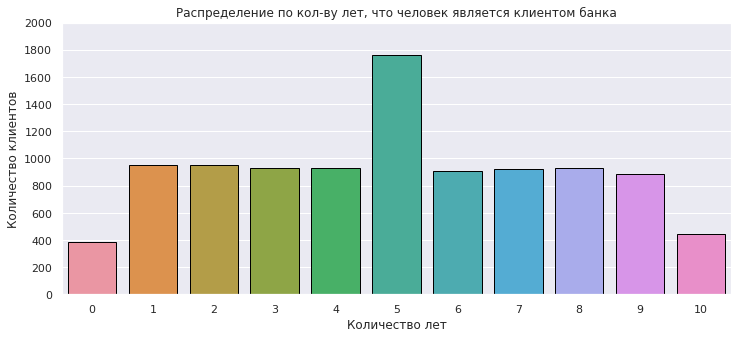

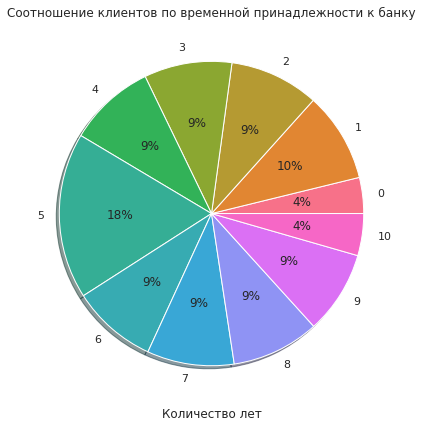

In [19]:
# Распределение по кол-ву лет, что человек является клиентом банка


# Посмотрим на кол-во мужчин и женщин
print(data['tenure'].value_counts(ascending=True))

# Посмотрим на столбчатый график 
sns.set(rc={'figure.figsize':(12,5)})
sns.countplot(data=data, x='tenure', ec='black')
plt.title('Распределение по кол-ву лет, что человек является клиентом банка')
plt.xlabel('Количество лет')
plt.ylabel('Количество клиентов')
plt.yticks(ticks=np.arange(0,2001,200))
plt.show()

# Посмотрим на круговую диаграмму
colors = sns.color_palette("husl", 11)
sns.set(rc={'figure.figsize':(7,7)})
data.groupby(['tenure']).count() .plot(kind='pie', y='customer_id',
  autopct='%1.0f%%', colors=colors, shadow=True, legend=False)
plt.title('Соотношение клиентов по временной принадлежности к банку')
plt.xlabel('Количество лет')
plt.ylabel('')
plt.show()

Весьма ровное соотношение: тех, кто является клиентом банка менее года или более 10 лет по 4% от общего числа (382 и 446 человек соответсвенно). Больше всего клиентов с 5 летним "стажем", их 1764 человека, что 18% от общей массы. Остальные "года" сформировались на уровне по 9% (для 1 года 10%) от всего количества клиентов.

count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: balance, dtype: float64


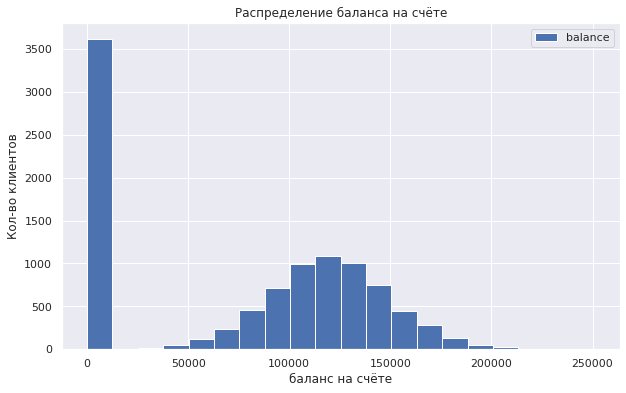

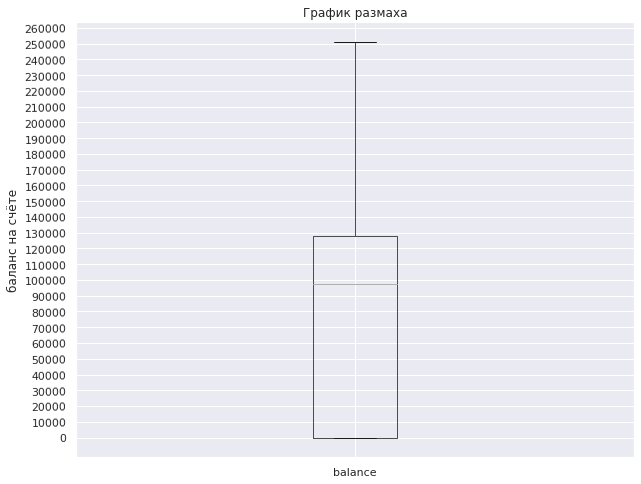

In [20]:
# Посмотрим на распределение баланса на счёте

#  Посмотрим на статистические данные столбца, которые дают представление о распределение значений
print(data['balance'].describe())

# гистограмма
data.plot(kind='hist', y='balance', bins=20, grid=True, figsize=(10, 6))
plt.title('Распределение баланса на счёте')
plt.xlabel('баланс на счёте')
plt.ylabel('Кол-во клиентов')
plt.show()

# график размаха
data.boxplot(column = 'balance', figsize=(10,8))
plt.title('График размаха')
plt.yticks(ticks=np.arange(0,260001,10000), rotation=1)
plt.ylabel('баланс на счёте')
plt.show()

Чуть меньше 1/4 клиентов имеют остаток на балансе равный 0. У остальной части клиентов остаток на банковском счете в целом распределен от 40 000 до 210 000. Из-за "нулевого баланса" средняя (75485) и медиана (97198) сильно разнаятся, при это на гистограмме пик на уровне 125000. 

1    5084
2    4590
3     266
4      60
Name: num_of_products, dtype: int64


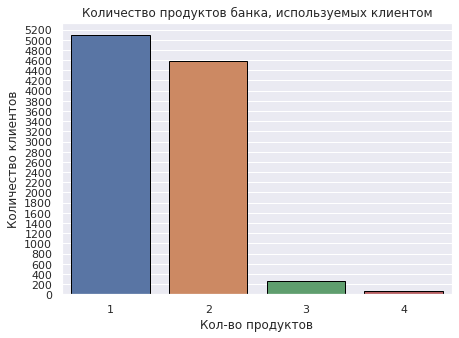

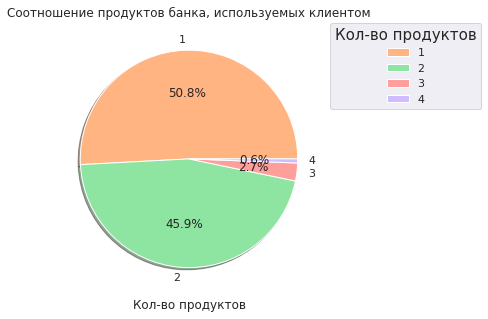

In [21]:
# Распределение по количеству банковских продуктов


# Посмотрим на кол-во продуктов
print(data['num_of_products'].value_counts())

# Посмотрим на столбчатый график 
sns.set(rc={'figure.figsize':(7,5)})
sns.countplot(data=data, x='num_of_products', ec='black')
plt.title('Количество продуктов банка, используемых клиентом')
plt.xlabel('Кол-во продуктов')
plt.ylabel('Количество клиентов')
plt.yticks(ticks=np.arange(0,5201,200))
plt.show()

# Посмотрим на круговую диаграмму
colors = sns.color_palette('pastel')[1:5]
data.groupby(['num_of_products']).count() .plot(kind='pie', y='customer_id',
  autopct='%0.1f%%', colors=colors, shadow=True)
plt.title('Соотношение продуктов банка, используемых клиентом')
plt.xlabel('Кол-во продуктов')
plt.ylabel('')
legend = plt.legend(title = "Кол-во продуктов", title_fontsize = 15, bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()


Выборки по количеству продуктов, используемых клиентом, очень сильно разнятся. Так тех, кто пользуется 1 продуктом 5084 человека (почти 51% от общего числа), а тех, у кото 4 продукта, всего 64 человека (0,6%). Таким образом, клиенты, используемые 1 или 2 продукта, составляют почти 97% от общей массы.

1    7055
0    2945
Name: has_cr_card, dtype: int64


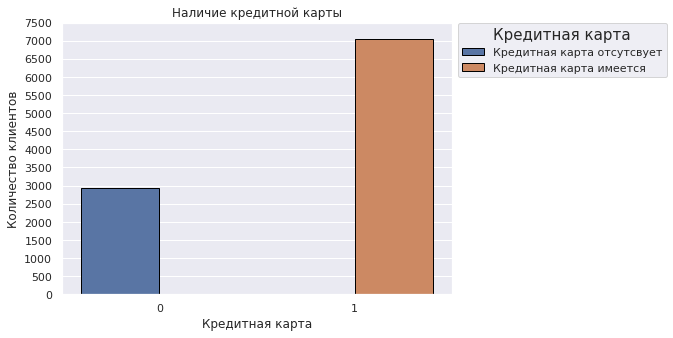

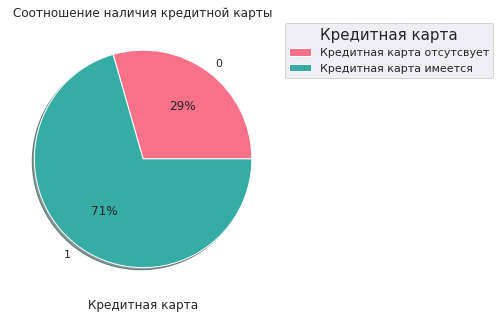

In [22]:
# Наличие кредитной карты


# Посмотрим на кол-во тех, у кого кредитная карта есть и нет
print(data['has_cr_card'].value_counts())

# Посмотрим на столбчатый график 
sns.set(rc={'figure.figsize':(7,5)})
sns.countplot(data=data, x='has_cr_card', ec='black', hue='has_cr_card')
plt.title('Наличие кредитной карты')
plt.xlabel('Кредитная карта')
plt.ylabel('Количество клиентов')
plt.yticks(ticks=np.arange(0,7501,500))
legend = plt.legend(['Кредитная карта отсутсвует', 'Кредитная карта имеется'], title = "Кредитная карта",
                     title_fontsize = 15, bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

# Посмотрим на круговую диаграмму
colors = sns.color_palette("husl", 2)
data.groupby(['has_cr_card']).count() .plot(kind='pie', y='customer_id',
  autopct='%1.0f%%', colors=colors, shadow=True)
plt.title('Соотношение наличия кредитной карты')
plt.xlabel('Кредитная карта')
plt.ylabel('')
legend = plt.legend(['Кредитная карта отсутсвует', 'Кредитная карта имеется'], title = "Кредитная карта",
                     title_fontsize = 15, bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

У 71% имеется кредитная карта, 7055 клиентов. Выборки неравнозначные.

1    5151
0    4849
Name: is_active_member, dtype: int64


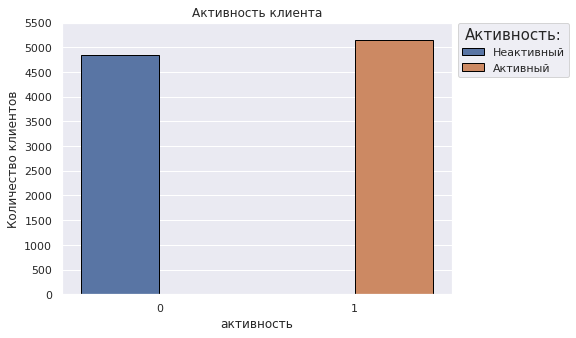

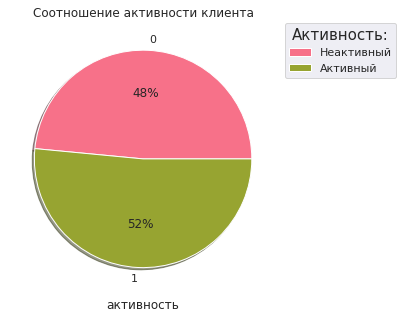

In [23]:
# Активность клиента

# Посмотрим на кол-во активных клиентов
print(data['is_active_member'].value_counts())

# Посмотрим на столбчатый график 
sns.set(rc={'figure.figsize':(7,5)})
sns.countplot(data=data, x='is_active_member', ec='black', hue='is_active_member')
plt.title('Активность клиента')
plt.xlabel('активность')
plt.ylabel('Количество клиентов')
plt.yticks(ticks=np.arange(0,5501,500))
legend = plt.legend(['Неактивный', 'Активный'], title = "Активность:",
                     title_fontsize = 15, bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

# Посмотрим на круговую диаграмму
colors = sns.color_palette("husl", 4)
data.groupby(['is_active_member']).count() .plot(kind='pie', y='customer_id',
  autopct='%1.0f%%', colors=colors, shadow=True)
plt.title('Соотношение активности клиента')
plt.xlabel('активность')
plt.ylabel('')
legend = plt.legend(['Неактивный', 'Активный'], title = "Активность:",
                     title_fontsize = 15, bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

Распределение активности клиентов близка к равномерной: 48% неактивных клиентов (4849 человек) на 52% активных (5151 человек)

count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: balance, dtype: float64


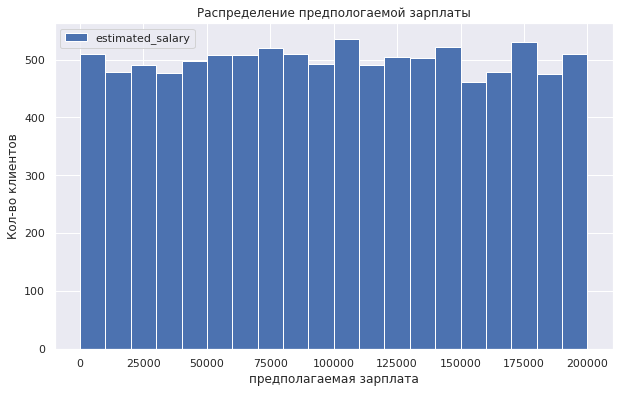

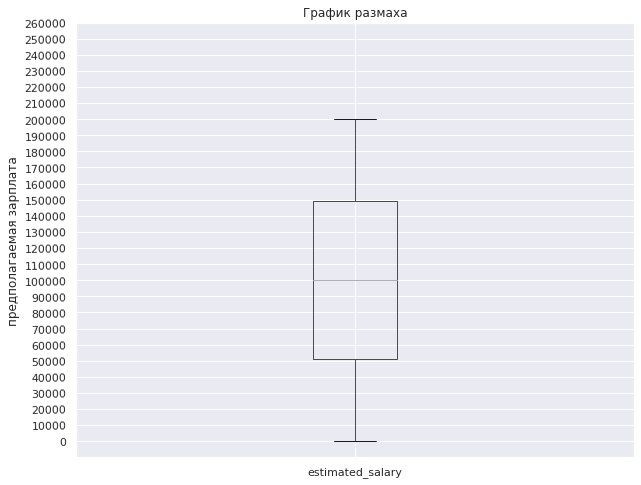

In [24]:
# Посмотрим как распределеяется предполагаемая зарплата

#  Посмотрим на статистические данные столбца, которые дают представление о распределение значений
print(data['balance'].describe())

# гистограмма
data.plot(kind='hist', y='estimated_salary', bins=20, grid=True, figsize=(10, 6))
plt.title('Распределение предпологаемой зарплаты')
plt.xlabel('предполагаемая зарплата')
plt.ylabel('Кол-во клиентов')
plt.show()

# график размаха
data.boxplot(column = 'estimated_salary', figsize=(10,8))
plt.title('График размаха')
plt.yticks(ticks=np.arange(0,260001,10000), rotation=1)
plt.ylabel('предполагаемая зарплата')
plt.show()

Медианна в ~ 97 тыс сильно отличается от средней в ~ 76 тыс. Предполагаемая зарплата равномерна распределена во всем диапозоне. Выбросы отсутсвуют.

0    7963
1    2037
Name: exited, dtype: int64


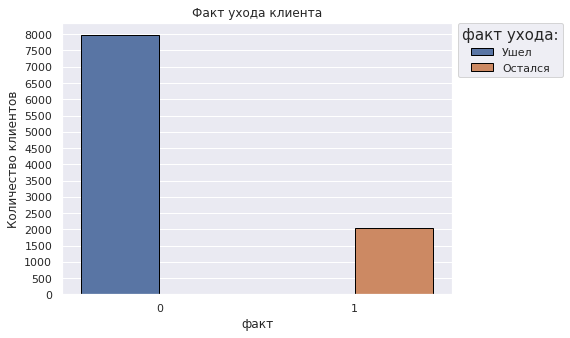

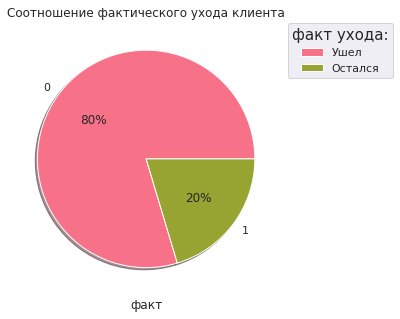

In [25]:
# exited
# Факт ухода клиента


# Посмотрим на то, ушел клиент или нет
print(data['exited'].value_counts())

# Посмотрим на столбчатый график 
sns.set(rc={'figure.figsize':(7,5)})
sns.countplot(data=data, x='exited', ec='black', hue='exited')
plt.title('Факт ухода клиента')
plt.xlabel('факт')
plt.ylabel('Количество клиентов')
plt.yticks(ticks=np.arange(0,8001,500))
legend = plt.legend(['Ушел', 'Остался'], title = "факт ухода:",
                     title_fontsize = 15, bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

# Посмотрим на круговую диаграмму
colors = sns.color_palette("husl", 4)
data.groupby(['exited']).count() .plot(kind='pie', y='customer_id',
  autopct='%1.0f%%', colors=colors, shadow=True)
plt.title('Соотношение фактического ухода клиента')
plt.xlabel('факт')
plt.ylabel('')
legend = plt.legend(['Ушел', 'Остался'], title = "факт ухода:",
                     title_fontsize = 15, bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

80% клиентов, а это 7963 человека, покинули банк. Выборка неравномерна.

***Факторы больше всего влияющие на уход клиента из банка***

С помощью техники прямого кодирования или отображения (англ. One-Hot Encoding, OHE) преобразуем категориальные признаки в численные в столбцах "gender" и "geography".  Столбец "surname" трогать не будем, т.к. это уникальный индификатор клиента и на уход из банка никак не влияет.

In [26]:
# # Что бы не попасть в дамми-ловушку (англ. dummy trap, «ловушка фиктивных признаков») уберем один столбец
# вызовом функции pd.get_dummies() с аргументом drop_first (от англ. «сбросьте первый»).
# Он удаляет первую колонку и передаётся как drop_first=True

# Удалим из нашего датафрейма столбцы, невлияющие на дальнейшие исследования
data = data.drop(['row_number', 'customer_id', 'surname'], axis=1)

data = pd.get_dummies(data, drop_first=True)

data.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [27]:
# Переименуем столбцы

data = data.rename(
    columns = {'geography_Germany': 'germany', 
    'geography_Spain': 'spain', 
    'gender_Male': 'gender'}
) 

data.columns

Index(['credit_score', 'age', 'tenure', 'balance', 'num_of_products',
       'has_cr_card', 'is_active_member', 'estimated_salary', 'exited',
       'germany', 'spain', 'gender'],
      dtype='object')

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   age               10000 non-null  int64  
 2   tenure            10000 non-null  int64  
 3   balance           10000 non-null  float64
 4   num_of_products   10000 non-null  int64  
 5   has_cr_card       10000 non-null  int64  
 6   is_active_member  10000 non-null  int64  
 7   estimated_salary  10000 non-null  float64
 8   exited            10000 non-null  int64  
 9   germany           10000 non-null  uint8  
 10  spain             10000 non-null  uint8  
 11  gender            10000 non-null  uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


In [33]:
# Воспользуемся методом корреляции и хитмепом для наблюдения зависимостей

# Нам нужен список с параметрами для проверки
corr_columns = [
    'exited',
    'credit_score',
    'gender',
    'age',
    'tenure',
    'balance',
    'num_of_products',
    'has_cr_card',
    'is_active_member',
    'estimated_salary',
    'germany',
    'spain']
# выводим матрицу корреляции
corr_matrix = data[corr_columns].corr()
display(corr_matrix)

,exited,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,germany,spain
exited,1.000000,-0.027094,-0.106512,0.285323,-0.015968,0.118533,-0.047820,-0.007138,-0.156128,0.012097,0.173488,-0.052667
credit_score,-0.027094,1.000000,-0.002857,-0.003965,-0.000307,0.006268,0.012238,-0.005458,0.025651,-0.001384,0.005538,0.004780
gender,-0.106512,-0.002857,1.000000,-0.027544,0.012205,0.012087,-0.021859,0.005766,0.022544,-0.008112,-0.024628,0.016889
age,0.285323,-0.003965,-0.027544,1.000000,-0.014674,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.046897,-0.001685
tenure,-0.015968,-0.000307,0.012205,-0.014674,1.000000,-0.007417,0.011707,0.026293,-0.031062,0.009343,-0.003191,0.000389
balance,0.118533,0.006268,0.012087,0.028308,-0.007417,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.401110,-0.134892
num_of_products,-0.047820,0.012238,-0.021859,-0.030680,0.011707,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.010419,0.009039
has_cr_card,-0.007138,-0.005458,0.005766,-0.011721,0.026293,-0.014858,0.003183,1.000000,-0.011866,-0.009933,0.010577,-0.013480
is_active_member,-0.156128,0.025651,0.022544,0.085472,-0.031062,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.020486,0.016732
estimated_salary,0.012097,-0.001384,-0.008112,-0.007201,0.009343,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.010297,-0.006482


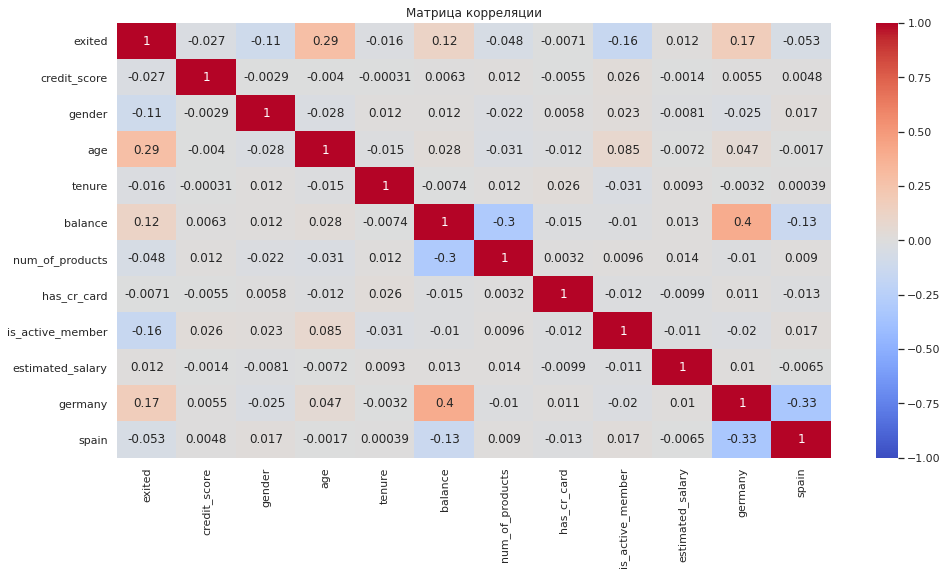

In [34]:
# Визуализируем
plt.figure(figsize = (16, 8))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.title('Матрица корреляции')
plt.show()

Хитмеп нам показывает, что все параметры не сильно коррелируются с целевым признаком. Есть средняя линейная положительная связь между возрастом и оттоком клиентов. Возможно зависимость сложнее.

Столбцы "row_number", "customer_id", "surname" не берем в расчет, т.к. в них уникальная информация, не влияющая на показатель ухода клиента из банка.

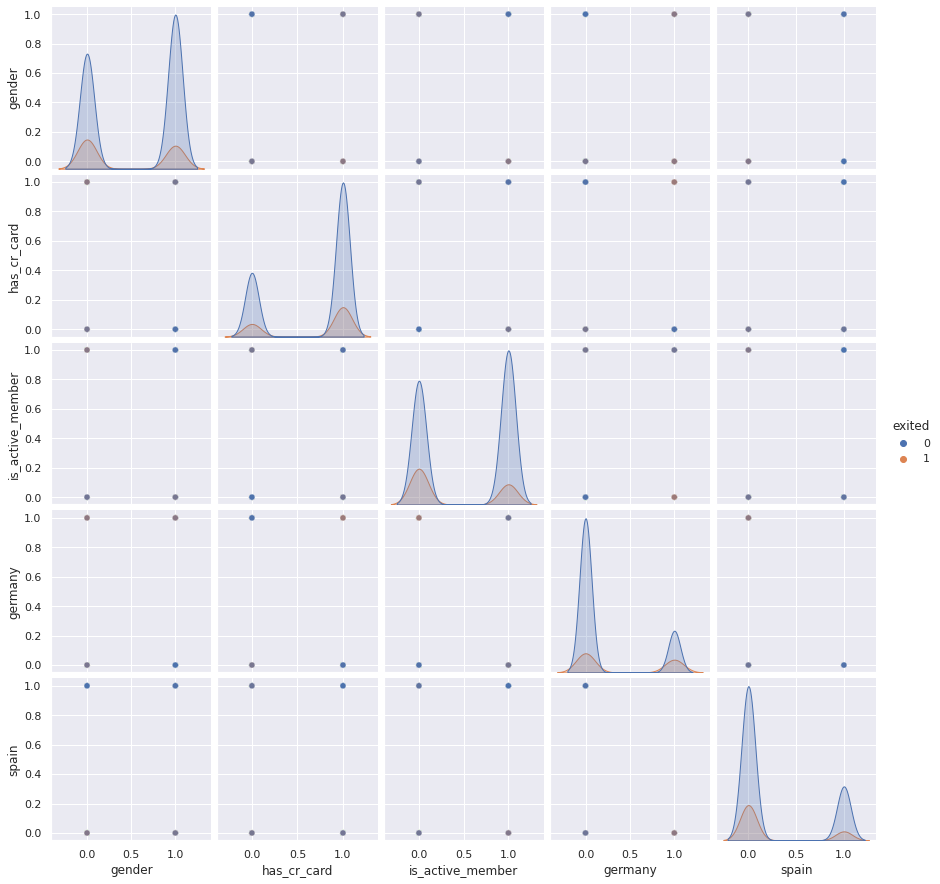

In [35]:
# Построим pair.plot для отображения зависимостей категориальных признаков в сравнении exited (0 - ушел, 1 - остался)
 
# создаем список категориальных признаков
category = ['exited', 'gender', 'has_cr_card', 'is_active_member', 'germany', 'spain']
# строим график
sns.pairplot(data[category], diag_kind='kde', hue='exited', plot_kws={'alpha': 0.3})
plt.show()

Что мы видим по pair.plot: Клиентов-мужчин покинуло больше банк, чем женщин и клиентов-женщин осталось чуть больше в банке. Так же больше клиентов покинули банк у кого были кредитные карты, больше активных клиентов ушло, и преобладающая часть была из Франции ( понять это мы можем по тому, что клиент не относится к Германии или Испании). В банке больше остались клиенты: так же с кредитной картой, неактивные клиенты. Так же можно сказать, что данные не сбалансированы.

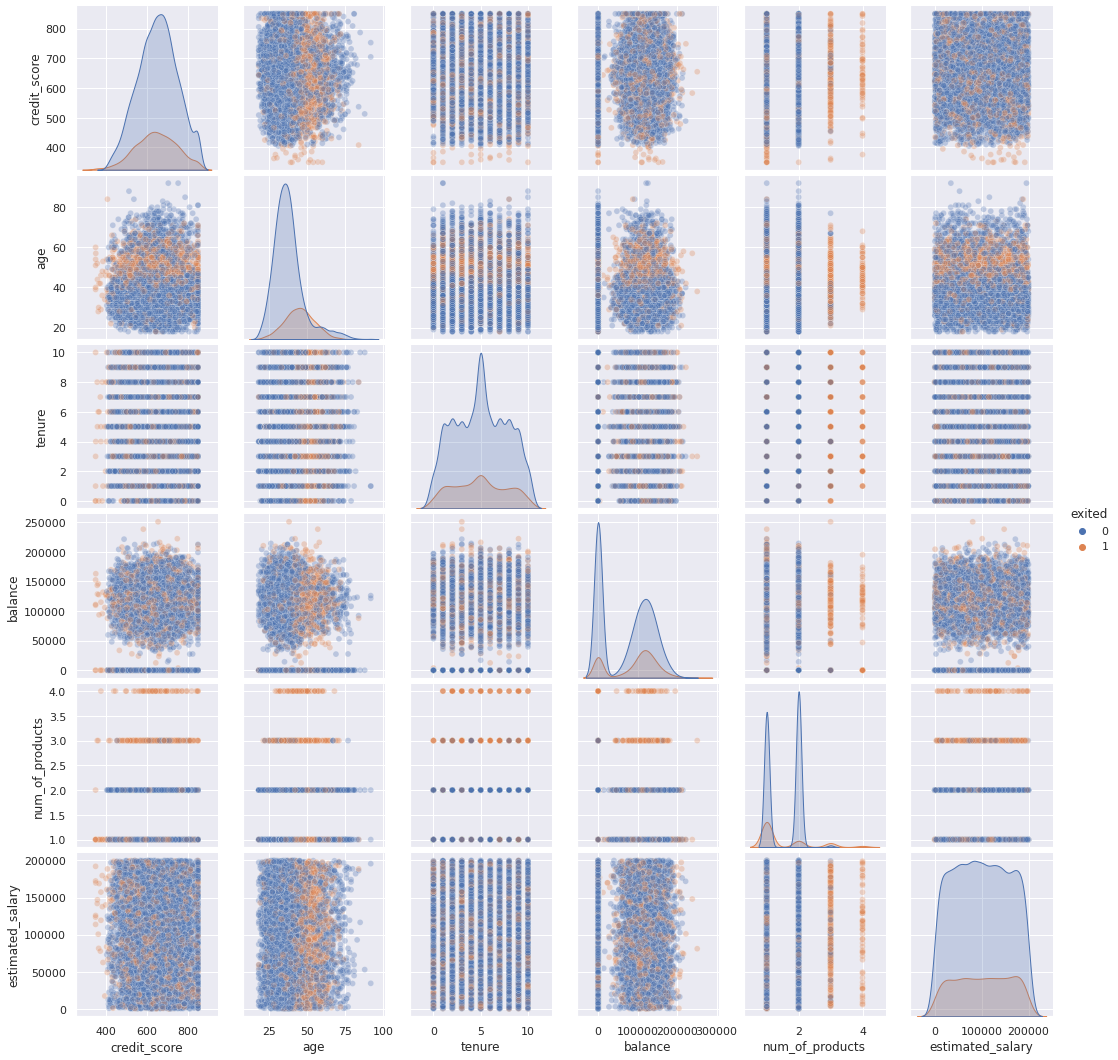

In [36]:
# Построим pair.plot для отображения зависимостей количественных признаков в сравнении exited (0 - ушел, 1 - остался)

# создаем список количественных признаков
quantity = ['exited', 'credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
# строим график
sns.pairplot(data[quantity], diag_kind='kde', hue='exited', plot_kws={'alpha': 0.3})
plt.show()

из оставшихся в банке клиентов преобладают люди в возрасте от 42 до 60 лет, с 3-4 продуктами в банке. В целом трудно проследить более точные закономерности, на это, в том числе, влияет несбалансированность данных.

## Исследование задачи

Исследуем баланс классов, обучим модель без учёта дисбаланса

In [37]:
# Объявим переменные признака и цели
# features = data.drop(['row_number', 'customer_id', 'surname', 'exited'], axis=1) #  признаки для обущающей модели
features = data.drop(['exited'], axis=1) #  признаки для обущающей модели
target = data['exited'] # записываем цель (задача классификации)

display(features.head())

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,germany,spain,gender
0,619,42,2,0.00,1,1,1,101348.88,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0


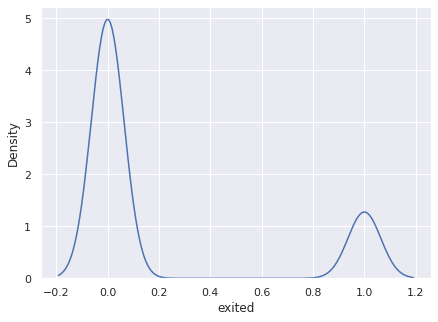

In [38]:
# Посмотри на распределение целевого признака, что бы в дальнейшем понимать допустили ли мы ощибку и насколько она критична
sns.kdeplot(target)
plt.show()

С помощью функции train_test_split (от англ. «разделить на обучающую и тестовую») разобьем датасет на обучающую, валидационную и тестовую выборки. Спрятанной тестовой выборки нет. Исходные данные разделим в соотношении 3:1:1

In [39]:
#  Обучающая выборка
# В размер валидационной выборки (test_size) мы пишем 0,4 (выражается в долях — от 0 до 1), т.к. 
# соотношении 3:1:1 и на валидационная и тестовая выборку отправляем 40% исходных данных

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.4, random_state=12345)

# Смотрим размер выборки 
print(features_train.shape)
print(target_train.shape)

(6000, 11)
(6000,)


In [40]:
#  Валидационная и тестовая выборки
# test_size = 0.5, выборки делим пополам

features_test, features_valid, target_test, target_valid = train_test_split(
    features_test, target_test, test_size=0.5, random_state=12345)

# Смотрим размер выборки 
print('Размер валидационной выборки:\n', features_valid.shape, '\n', target_valid.shape)
print('')
print('Размер тестовой  выборки:\n', features_test.shape, '\n', target_test.shape)

Размер валидационной выборки:
 (2000, 11) 
 (2000,)

Размер тестовой  выборки:
 (2000, 11) 
 (2000,)


Мы с вами разбили данные на обучающую, валидационную и тестовую выборки. На обучение ушло 6000 записей, на валидационную и тестовую по 2000 записи для каждой выборки соответсвенно.

**Создадим копию датафрейма для дальнейшего масштабирования методом Логистической регресии**

***Хоть деревья решений и алгоритмы основанные на них (случайный лес, градиентный бустинг) не зависят от масштаба признаков, мы все равно создадим отдельные признаки и целевые признаки для масштабирования***

(P.S. *При дальнейших расчетах Масштабирование незначительно повлияло в худшую сторону на результаты модели случайного леса, на результаты дерева решений влияние было нулевым*)

In [41]:
# Cоздадим копию датафрейма для дальнейшего масштабирования методом Линейной регресии
data_logistic = deepcopy(data)

# так же объявим переменные признака и цели
# features_logistic = data_logistic.drop(['row_number', 'customer_id', 'surname', 'exited'], axis=1)
features_logistic = data_logistic.drop(['exited'], axis=1)
target_logistic = data_logistic['exited']

#  Обучающая выборка
features_train_logistic, features_test_logistic, target_train_logistic, target_test_logistic = train_test_split(
    features_logistic, target_logistic, test_size=0.4, random_state=12345)

#  Валидационная и тестовая выборки
features_test_logistic, features_valid_logistic, target_test_logistic, target_valid_logistic = train_test_split(
    features_test_logistic, target_test_logistic, test_size=0.5, random_state=12345)

In [42]:
# Масштабируем признаки с помощью стандартизация данных.

# Чтобы не появлялось предупреждение SettingWithCopy добавим в код строчку:
pd.options.mode.chained_assignment = None

# выбираем столбцы с количественными данными для масштабирования
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

# Создадим объект StandardScaler (структура для стандартизации данных)  и настроим его на обучающих данных. 
# Настройка — это вычисление среднего и дисперсии
scaler = StandardScaler()
scaler.fit(features_train_logistic[numeric])

# Преобразуем обучающую и валидационную выборки функцией transform().
features_train_logistic[numeric] = scaler.transform(features_train_logistic[numeric])
features_valid_logistic[numeric] = scaler.transform(features_valid_logistic[numeric])
features_test_logistic[numeric] = scaler.transform(features_test_logistic[numeric])

# смотрим
display(features_train_logistic.head())

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,germany,spain,gender
7479,-0.886751,-0.373192,1.082280,1.232271,-0.891560,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,1.082280,0.600563,-0.891560,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.736780,1.027098,0.830152,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.354656,-1.233163,0.830152,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-1.100592,1.140475,-0.891560,0,0,1.524268,1,0,0


**Построим модели без учета баланса**

Исследуем качество разных моделей, выберем оптимальные гиперпараметры.

В качестве моделей буем рассматривать:
- Решающее дерево (Decision Tree Classifier)

это структура данных для классификации деревом решений. Импортируем её из библиотеки:
`from sklearn.tree import DecisionTreeClassifier`

- Cлучайный лес (RandomForestClassifier)

Алгоритм обучает большое количество независимых друг от друга деревьев, а потом принимает решение на основе голосования. Случайный лес помогает улучшить результат предсказания и избежать переобучения. В библиотеке sklearn алгоритм случайного леса RandomForestClassifier находится в модуле  sklearn.ensemble (от фр. «вместе»). Импортируем его:
`from sklearn.ensemble import RandomForestClassifier`

- Логистическая регрессия (Logistic Regression)

Логистическая регрессия применяется для прогнозирования вероятности возникновения некоторого события по значениям множества признаков.
Модель LogisticRegression лежит в модуле sklearn.linear_model (от англ. «линейная модель») библиотеки sklearn. Импортируем его:
`from sklearn.linear_model import LogisticRegression`

Для дальнейшего исследования воспользуемся `F1-мера` (англ. F1-score). Это среднее гармоническое полноты и точности. Единица в F1 означает, что соотношение полноты и точности равно 1:1. 

In [49]:
# Логистическая регрессия
model_logistic = LogisticRegression()
model_logistic.fit(features_train_logistic, target_train_logistic)
predicted_valid = model_logistic.predict(features_valid_logistic)

logistic_no_balance = f1_score(target_valid_logistic, predicted_valid)
print('F1:', logistic_no_balance)

F1: 0.27177700348432055


In [50]:
%%time
# Решающее дерево 

best_model = None
best_f1 = 0

for depth in range(1, 21, 1):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth) # обучим модель с заданной глубиной дерева
    model_tree.fit(features_train, target_train) # обучим модель
    predicted_valid = model_tree.predict(features_valid) # получим предсказания модели
    f1 = f1_score(target_valid, predicted_valid) # посчитаем метрику f1
    print(f" max_depth = {depth}")
    print(f"f1 = {f1}")
    if f1 > best_f1:
        best_depth= depth # сохраним наилучшее показание глубины дерева
        best_model = model_tree # сохраним наилучшую модель
        best_f1 = f1 # сохраним наилучшее значение метрики accuracy на валидационных данных

tree_no_balance = best_f1    
print('')
print(f"Лучшее значение f1 {tree_no_balance}, при глубине {best_depth}")

 max_depth = 1
f1 = 0.0
 max_depth = 2
f1 = 0.4986301369863014
 max_depth = 3
f1 = 0.3795620437956204
 max_depth = 4
f1 = 0.48307692307692307
 max_depth = 5
f1 = 0.5015772870662459
 max_depth = 6
f1 = 0.5359877488514548
 max_depth = 7
f1 = 0.4976816074188563
 max_depth = 8
f1 = 0.48773006134969327
 max_depth = 9
f1 = 0.5234159779614326
 max_depth = 10
f1 = 0.5035765379113019
 max_depth = 11
f1 = 0.4993252361673414
 max_depth = 12
f1 = 0.4993498049414824
 max_depth = 13
f1 = 0.4948186528497409
 max_depth = 14
f1 = 0.4974747474747475
 max_depth = 15
f1 = 0.47908745247148293
 max_depth = 16
f1 = 0.47466007416563655
 max_depth = 17
f1 = 0.4843373493975903
 max_depth = 18
f1 = 0.47102342786683105
 max_depth = 19
f1 = 0.47630619684082626
 max_depth = 20
f1 = 0.48107448107448103

Лучшее значение f1 0.5359877488514548, при глубине 6
CPU times: user 458 ms, sys: 19.7 ms, total: 478 ms
Wall time: 553 ms


In [51]:
%%time
# Cлучайный лес

best_f1 = 0
best_est = 0
best_depth = 0

for est in range(10, 101, 10):
    for depth in range (1, 21, 1):
        model_random = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_random.fit(features_train, target_train)
        predicted_valid = model_random.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        print(f" n_estimators = {est}")
        print(f" max_depth = {depth}")
        print(f" f1 = {f1}")
        if f1 > best_f1:
            best_model = model_random
            best_f1 = f1
            best_est = est
            best_depth = depth

random_forest_no_balance = best_f1
print('')        
print(
    f"Лучшее значение f1 {random_forest_no_balance}," 
    f" при глубине {best_depth},"
    f" кол-ве деревьев {best_est}"
)

 n_estimators = 10
 max_depth = 1
 f1 = 0.0
 n_estimators = 10
 max_depth = 2
 f1 = 0.18987341772151897
 n_estimators = 10
 max_depth = 3
 f1 = 0.20459290187891438
 n_estimators = 10
 max_depth = 4
 f1 = 0.42214532871972327
 n_estimators = 10
 max_depth = 5
 f1 = 0.4584717607973422
 n_estimators = 10
 max_depth = 6
 f1 = 0.4623115577889447
 n_estimators = 10
 max_depth = 7
 f1 = 0.48803827751196177
 n_estimators = 10
 max_depth = 8
 f1 = 0.47896440129449835
 n_estimators = 10
 max_depth = 9
 f1 = 0.5086342229199371
 n_estimators = 10
 max_depth = 10
 f1 = 0.5290519877675841
 n_estimators = 10
 max_depth = 11
 f1 = 0.5195195195195195
 n_estimators = 10
 max_depth = 12
 f1 = 0.5269461077844312
 n_estimators = 10
 max_depth = 13
 f1 = 0.5250737463126844
 n_estimators = 10
 max_depth = 14
 f1 = 0.5291479820627802
 n_estimators = 10
 max_depth = 15
 f1 = 0.5545722713864306
 n_estimators = 10
 max_depth = 16
 f1 = 0.5166163141993957
 n_estimators = 10
 max_depth = 17
 f1 = 0.5255255255255256

**Подитог** 

Рассматривая F-1 меру на несбалансированных данных, но с масштабированными и переведенными категориальными признаками, можно сделать следующие выводы:

Лучшей обучающей моделью оказалась:

`Cлучайный лес (RandomForestClassifier)`
- Лучшее значение f1 **0.5568862275449102**, при следующих гиперпараметрах: глубина дерева равная 18, а количество деревьев равно 50.

На втором месте

`Решающее дерево (DecisionTreeClassifier)`
- F-1 лучшей модели: **0.5359877488514548** при глубине дерева равной 6

*Для этих двух моделей с помощью функции мы подбрали лучшие показатиели глубины дерева и кол-ва деревьев для RandomForestClassifier.*

На третьем месте

`Логистическая регрессия (Logistic Regression)`
- F1:  **0.27177700348432055**

Показатели далеки от единицы и даже не дотягивают до условных 0,59

In [52]:
# Создадим таблицу результатов 

result_table = pd.DataFrame(index = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForest'],
                columns = ['f1_no_balance', 'f1_class_weight', 'f1_upsampling', 'f1_downsampling', 'AUC_ROC'])

result_table.loc['LogisticRegression', 'f1_no_balance'] = round(logistic_no_balance, 3)
result_table.loc['DecisionTreeClassifier', 'f1_no_balance'] = round(tree_no_balance, 3)
result_table.loc['RandomForest', 'f1_no_balance'] = round(random_forest_no_balance, 3)

result_table

,f1_no_balance,f1_class_weight,f1_upsampling,f1_downsampling,AUC_ROC
LogisticRegression,0.272,NaN,NaN,NaN,NaN
DecisionTreeClassifier,0.536,NaN,NaN,NaN,NaN
RandomForest,0.557,NaN,NaN,NaN,NaN


## Борьба с дисбалансом

Улучшим качество модели, учитывая дисбаланс классов. Обучим разные модели и найдем лучшую

Придадим объектам редкого класса больший вес с помощтю аргумента `class_weight`. Сделаем веса классов сбалансированными. Посмотрим, как изменится значение F1-меры у каждой из моделей.

In [53]:
# Логистическая регрессия
model_logistic_weight = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_logistic_weight.fit(features_train_logistic, target_train_logistic)
predicted_valid = model_logistic_weight.predict(features_valid_logistic)
logistic_class_weight = f1_score(target_valid_logistic, predicted_valid)

print('LogisticRegression F1:', logistic_class_weight)

LogisticRegression F1: 0.47619047619047616


In [54]:
# # Решающее дерево. Используем лучшую полученную глубину дерева

# model_tree_weight = DecisionTreeClassifier(random_state=12345, max_depth=6, class_weight='balanced') 
# model_tree_weight.fit(features_train, target_train)
# predicted_valid = model_tree_weight.predict(features_valid)
# tree_class_weight = f1_score(target_valid, predicted_valid)

# print('DecisionTreeClassifier F1:', tree_class_weight)

In [55]:
%%time
# Решающее дерево.

best_model = None
best_f1 = 0

for depth in range(1, 21, 1):
    model_tree_weight = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model_tree_weight.fit(features_train, target_train)
    predicted_valid = model_tree_weight.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_depth= depth
        best_model = model_tree_weight
        best_f1 = f1

tree_class_weight = best_f1    
print('')
print(f"Лучшее значение f1 {tree_class_weight}, при глубине {best_depth}")


Лучшее значение f1 0.5809128630705395, при глубине 5
CPU times: user 443 ms, sys: 0 ns, total: 443 ms
Wall time: 450 ms


In [57]:
%%time
# Cлучайный лес

best_f1 = 0
best_est = 0
best_depth = 0

for est in range(10, 101, 10):
    for depth in range (1, 21, 1):
        model_random_weight = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, 
                                                     class_weight='balanced')
        model_random_weight.fit(features_train, target_train)
        predicted_valid = model_random_weight.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        if f1 > best_f1:
            best_model = model_random_weight
            best_f1 = f1
            best_est = est
            best_depth = depth

random_class_weight = best_f1
print('')        
print(
    f"Лучшее значение f1 {random_class_weight}," 
    f" при глубине {best_depth},"
    f" кол-ве деревьев {best_est}"
)


Лучшее значение f1 0.6285714285714286, при глубине 8, кол-ве деревьев 60
CPU times: user 57.6 s, sys: 263 ms, total: 57.9 s
Wall time: 57.9 s


Показатели f-1 для:
- Логистической регрессии улучшились почти в 2 раза, стало **0.47619047619047616**;
- Решающего дерева улучшились незначительно, на 0,05, стало **0.5809128630705395**;
- Случайного леса улучшились значительнее: было **0.5568862275449102** стало **0.6285714285714286**

Отлично, **показатель f-1 стал равен ~0.62**, что больше условленной метрики в 0.59

Посмотрим, сможем ли мы улучишить еще данную метрику, рассмотрим методы `upsampling` (Увеличение выборки) и `downsampling` (Уменьшение выборки).

Смысл преобразования в следующем:
- Разделяется обучающая выборка на отрицательные и положительные объекты;
- Для `upsampling` копируются несколько раз положительные объекты. Для `downsampling` случайным образом отбросывается часть из отрицательных объектов;
- С учётом полученных данных создается новая обучающая выборка;
- Данные перемешиваются: идущие друг за другом одинаковые вопросы не помогут обучению, положительные не должны идти следом за отрицательными: алгоритмам будет сложнее обучаться.

In [59]:
result_table.loc['LogisticRegression', 'f1_class_weight'] = round(logistic_no_balance, 3)
result_table.loc['DecisionTreeClassifier', 'f1_class_weight'] = round(tree_class_weight, 3)
result_table.loc['RandomForest', 'f1_class_weight'] = round(random_class_weight, 3)

result_table

,f1_no_balance,f1_class_weight,f1_upsampling,f1_downsampling,AUC_ROC
LogisticRegression,0.272,0.272,NaN,NaN,NaN
DecisionTreeClassifier,0.536,0.581,NaN,NaN,NaN
RandomForest,0.557,0.629,NaN,NaN,NaN


In [60]:
# Увеличение выборки

# Создадим функцию, которая возвращает признаки и целевой признак после операции upsampling
def upsample(features, target, repeat):
    
# Разделим обучающую выборку на отрицательные и положительные объекты. 
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

# Продублируем объекты положительного класса и объединим их с объектами отрицательного класса.
# Чтобы соединить таблицы, воспользуйтесь функцией pd.concat()
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

# Перемешаем данные с помощью функции shuffle(), импортированной из модуля sklearn.utils
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)

features_upsampled_logistic, target_upsampled_logistic = upsample(features_train_logistic, target_train_logistic, 4)

print('')
print(features_upsampled_logistic.shape)
print(target_upsampled_logistic.shape)

(9588, 11)
(9588,)

(9588, 11)
(9588,)


In [61]:
# Применяем к моделям

# Логистическая регрессия
model_logostic_upsampled = LogisticRegression(random_state=12345, solver='liblinear')
model_logostic_upsampled.fit(features_upsampled_logistic, target_upsampled_logistic)
predicted_valid = model_logostic_upsampled.predict(features_valid_logistic)
logistic_upsampling = f1_score(target_valid_logistic, predicted_valid)

print('LogisticRegression F1:', logistic_upsampling)

LogisticRegression F1: 0.47619047619047616


In [62]:
%%time
# Решающее дерево 

best_model = None
best_f1 = 0

for depth in range(1, 21, 1):
    model_tree_upsampled = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree_upsampled.fit(features_upsampled, target_upsampled)
    predicted_valid = model_tree_upsampled.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_depth= depth
        best_model = model_tree_upsampled
        best_f1 = f1

tree_upsampling = best_f1
print('')
print(f"Лучшее значение f1 {tree_upsampling}, при глубине {best_depth}")


Лучшее значение f1 0.5809128630705395, при глубине 5
CPU times: user 538 ms, sys: 35.7 ms, total: 574 ms
Wall time: 628 ms


In [63]:
%%time
# Случайный лес, уменьшим кол-во деревьем до 60 и глубину до 15,
# так как ранее лучшие показатели не поднимались выше заданных параметров

best_f1 = 0
best_est = 0
best_depth = 0

for est in range(10, 61, 10):
    for depth in range (1, 16, 1):
        model_random_upsampled = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_random_upsampled.fit(features_upsampled, target_upsampled)
        predicted_valid = model_random_upsampled.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        if f1 > best_f1:
            best_model = model_random_upsampled
            best_f1 = f1
            best_est = est
            best_depth = depth

random_upsampling = best_f1             
print('')        
print(
    f"Лучшее значение f1 {random_upsampling}," 
    f" при глубине {best_depth},"
    f" кол-ве деревьев {best_est}"
)


Лучшее значение f1 0.6238738738738739, при глубине 11, кол-ве деревьев 30
CPU times: user 19.8 s, sys: 80.5 ms, total: 19.8 s
Wall time: 19.9 s


Показатели f-1 с помощью `upsampling`:
- Для Логистической регрессии стали равны **0.47619047619047616**, чуть лучше чем просто с `class_weight` (0.4775086505190312)
- Для Решающего дерева изменений нет: стало **0.5809128630705395** было 0.5809128630705395;
- Для Случайного леса показатель f-1 равен **0.6238738738738739**, что похуже, чем только со сбалансированным весом **0.6285714285714286** 

In [64]:
result_table.loc['LogisticRegression', 'f1_upsampling'] = round(logistic_upsampling, 3)
result_table.loc['DecisionTreeClassifier', 'f1_upsampling'] = round(tree_upsampling, 3)
result_table.loc['RandomForest', 'f1_upsampling'] = round(random_upsampling, 3)

result_table

,f1_no_balance,f1_class_weight,f1_upsampling,f1_downsampling,AUC_ROC
LogisticRegression,0.272,0.272,0.476,NaN,NaN
DecisionTreeClassifier,0.536,0.581,0.581,NaN,NaN
RandomForest,0.557,0.629,0.624,NaN,NaN


In [65]:
# Уменьшение выборки

# Напишем функцию, которая вернёт признаки и целевой признак после операции downsampling
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

# Чтобы выбросить из таблицы случайные элементы, применим функцию sample(). 
# На вход она принимает аргумент frac (от англ. fraction, «доля»).
# Возвращает случайные элементы в таком количестве, чтобы их доля от исходной таблицы была равна frac
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(features_downsampled.shape)
print(target_downsampled.shape)

features_downsampled_logistic, target_downsampled_logistic = downsample(features_train_logistic, target_train_logistic, 0.25)
print('')
print(features_downsampled.shape)
print(target_downsampled.shape)

(2397, 11)
(2397,)

(2397, 11)
(2397,)


In [66]:
# Применяем к моделям

# Логистическая регрессия
model_logistic_downsampled = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_logistic_downsampled.fit(features_downsampled_logistic, target_downsampled_logistic)
predicted_valid = model_logistic_downsampled.predict(features_valid_logistic)
logistic_downsampling = f1_score(target_valid_logistic, predicted_valid)

print('LogisticRegression F1:', logistic_downsampling)

LogisticRegression F1: 0.48547008547008547


In [67]:
%%time
# Решающее дерево 

best_model = None
best_f1 = 0

for depth in range(1, 21, 1):
    model_tree_downsampled = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree_downsampled.fit(features_downsampled, target_downsampled)
    predicted_valid = model_tree_downsampled.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_depth= depth
        best_model = model_tree_downsampled
        best_f1 = f1

tree_downsampling = best_f1        
print('')
print(f"Лучшее значение f1 {tree_downsampling}, при глубине {best_depth}")


Лучшее значение f1 0.608066184074457, при глубине 5
CPU times: user 226 ms, sys: 3.97 ms, total: 230 ms
Wall time: 233 ms


In [68]:
%%time
# Случайный лес

best_f1 = 0
best_est = 0
best_depth = 0

for est in range(10, 61, 10):
    for depth in range (1, 16, 1):
        model_random_downsampled = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_random_downsampled.fit(features_downsampled, target_downsampled)
        predicted_valid = model_random_downsampled.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        if f1 > best_f1:
            best_model = model_random_downsampled
            best_f1 = f1
            best_est = est
            best_depth = depth

random_forest_downsampling = best_f1          
print('')        
print(
    f"Лучшее значение f1 {random_forest_downsampling}," 
    f" при глубине {best_depth},"
    f" кол-ве деревьев {best_est}"
)


Лучшее значение f1 0.5926640926640927, при глубине 7, кол-ве деревьев 20
CPU times: user 9.14 s, sys: 36.1 ms, total: 9.18 s
Wall time: 9.19 s


Показатели f-1 с помощью `downsampling`:
- Для Логистической регрессии стали равны **0.48547008547008547**, что лучше чем у `class_weight` или `upsampling` 
- Для Решающего дерева улучшение примерно на 0,02 до **0.608066184074457**;
- Для Случайного леса показатель f-1 ухудшился **0.5926640926640927**

Выборка у нас и так не большая, поэтому уменьшать ее нет смысла

In [69]:
result_table.loc['LogisticRegression', 'f1_downsampling'] = round(logistic_downsampling, 3)
result_table.loc['DecisionTreeClassifier', 'f1_downsampling'] = round(tree_downsampling, 3)
result_table.loc['RandomForest', 'f1_downsampling'] = round(random_forest_downsampling, 3)

result_table

,f1_no_balance,f1_class_weight,f1_upsampling,f1_downsampling,AUC_ROC
LogisticRegression,0.272,0.272,0.476,0.485,NaN
DecisionTreeClassifier,0.536,0.581,0.581,0.608,NaN
RandomForest,0.557,0.629,0.624,0.593,NaN


***Какие мы можем сделать выводы:***
- Лучше значение f-1 получилось при использовании метода *RandomForest* равное **0.6285714285714286**, при глубине 8, кол-ве деревьев 60 со сбалансированным весом.
- в *DecisionTreeClassifier* лучшее значение f-1 = **0.608066184074457**, при глубине 5 использование метода `downsampling`
- у *LogisticRegression* лучшее значение f-1 = **0.48547008547008547**, так же при использовании метода `downsampling`

Для полученных результатов проверим **ROC-кривую, или кривую ошибок**

Построить ROC-кривую поможет функция `roc_curve()` из модуля `sklearn.metrics`:

На вход она принимает значения целевого признака и вероятности положительного класса. Перебирает разные пороги и возвращает три списка: значения FPR (доля ложноположительных ответов), значения TPR (доля истинно положительных ответов) и рассмотренные пороги.

Чтобы выявить, как сильно наша модель отличается от случайной, посчитаем площадь под ROC-кривой — AUC-ROC (от англ. Area Under Curve ROC, «площадь под ROC-кривой»). Это новая метрика качества, которая изменяется от 0 до 1. AUC-ROC случайной модели равна 0.5.

AUC-ROC LogisticRegression: 0.741312394033019

AUC-ROC DecisionTreeClassifier: 0.6680061042977434

AUC-ROC RandomForest: 0.8504012316530025


<Figure size 504x360 with 0 Axes>

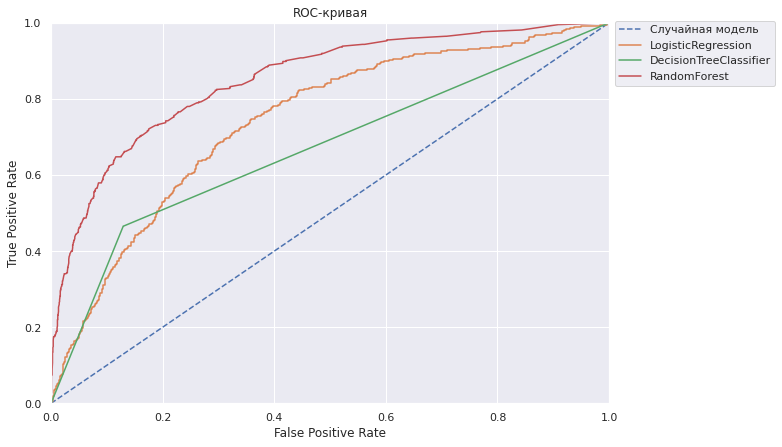

In [70]:
# Построим ROC-кривую и изобразим её на графике и посчитаем AUC-ROC

# ROC-кривая LogisticRegression
fpr_log, tpr_log, thresholds = roc_curve(target_valid_logistic,
                                         model_logistic_downsampled.predict_proba(features_valid_logistic)[:, 1])

logistic_roc = roc_auc_score(target_valid_logistic, model_logistic_downsampled.predict_proba(features_valid_logistic)[:, 1])
print('AUC-ROC LogisticRegression:', logistic_roc)
print('')

# ROC-кривая DecisionTreeClassifier
fpr_tree, tpr_tree, thresholds = roc_curve(target_valid, model_tree_upsampled.predict_proba(features_valid)[:, 1])

tree_roc = roc_auc_score(target_valid, model_tree_upsampled.predict_proba(features_valid)[:, 1])
print('AUC-ROC DecisionTreeClassifier:', tree_roc)
print('')

# ROC-кривая RandomForest
fpr_forest, tpr_forest, thresholds = roc_curve(target_valid, model_random_weight.predict_proba(features_valid)[:, 1])

random_roc = roc_auc_score(target_valid, model_random_weight.predict_proba(features_valid)[:, 1])
print('AUC-ROC RandomForest:', random_roc)

plt.figure()

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_log,tpr_log)
plt.plot(fpr_tree,tpr_tree)
plt.plot(fpr_forest,tpr_forest)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','LogisticRegression','DecisionTreeClassifier','RandomForest'),
           bbox_to_anchor=(1, 1.02), loc='upper left') 
plt.show()

Лучше значение AUC-ROC у RandomForest **0.8504012316530025**.

График RandomForest сильно отличается от слуайной модели

In [71]:
result_table.loc['LogisticRegression', 'AUC_ROC'] = round(logistic_roc, 3)
result_table.loc['DecisionTreeClassifier', 'AUC_ROC'] = round(tree_roc, 3)
result_table.loc['RandomForest', 'AUC_ROC'] = round(random_roc, 3)

result_table

,f1_no_balance,f1_class_weight,f1_upsampling,f1_downsampling,AUC_ROC
LogisticRegression,0.272,0.272,0.476,0.485,0.741
DecisionTreeClassifier,0.536,0.581,0.581,0.608,0.668
RandomForest,0.557,0.629,0.624,0.593,0.85


## Тестирование модели

Проведем финальное тестирование

Так как лучшей моделью оказался "Случайный лес" со значением 0.6285714285714286, при глубине 8, кол-ве деревьев 60 со сбалансированным весом, то тестовую выборку будем проводить на нем

In [72]:
# Объединим обучающую и валидационные выборки в надежде увеличить немного качество.

features_train_valid = pd.concat([features_train, features_valid])
target_train_valid = pd.concat([target_train, target_valid])

print(features_train_valid.shape)
print(target_train_valid.shape)

(8000, 11)
(8000,)


In [73]:
# Проверим модель на тестовой выборке по нашим параметрам
model_test = RandomForestClassifier(random_state=12345, n_estimators=60, max_depth=8,
            class_weight='balanced').fit(features_train_valid, target_train_valid)

predicted_test = model_test.predict(features_test)
print(f1_score(target_test, predicted_test))

0.6346555323590815


AUC-ROC тестовой выборки: 0.8573863258306669

AUC-ROC валидационной выборки: 0.8504012316530025


<Figure size 504x360 with 0 Axes>

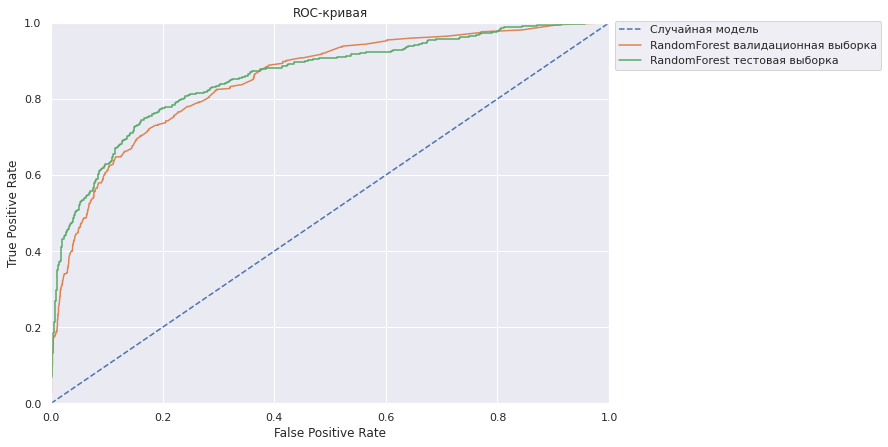

In [75]:
# Сравним валидационную выборку и тестовую 

print('AUC-ROC тестовой выборки:', roc_auc_score(target_test, model_test.predict_proba(features_test)[:, 1]))
print('')
print('AUC-ROC валидационной выборки:', roc_auc_score(target_valid, model_random_weight.predict_proba(features_valid)[:, 1]))

fpr_forest, tpr_forest, thresholds = roc_curve(target_valid, model_random_weight.predict_proba(features_valid)[:, 1])
fpr_test, tpr_test, thresholds = roc_curve(target_test, model_test.predict_proba(features_test)[:, 1])

plt.figure()

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_forest,tpr_forest)
plt.plot(fpr_test,tpr_test)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','RandomForest валидационная выборка','RandomForest тестовая выборка'),
           bbox_to_anchor=(1, 1.02), loc='upper left') 
plt.show()

Площадь под графиком тестовой выборки незначительно больше. Так же нам удалось улучшить показатель f-1 при параметрах глубины 8, кол-ва деревьев 60 и сбалансированном весе за счет объединения валидационной и обучающей выборок до **0.6346555323590815**.

# Вывод:

Мы просмотрели наш датафрейм по предоставленым историческим данным о поведении клиентов и расторжении договоров с банком «Бета-Банк». Нам была предоставлена собранная информация по 10 тысячам клиентам, без явных дубликатов, но с пропущенными значения в столбце "Tenure" - данные мы восстановили. Для удобства работы мы преобразовали названия столбцов, изменили тип столбцов, а так же проанализировали информацию, которая была нам предоставлена( возрастной критерий, соотношение страны проживания, гендерные принадлежности и т.д.). Попытались найти зависимости ухода клиента из банка. Так на момент предоставления данных 80% клиентов покинуло банк, только 20% осталось. С помощью техники прямого кодирования или отображения (англ. One-Hot Encoding, OHE) преобразовали категориальные признаки в численные. Посмотрели корреляцию признаков.

Мы построили систему, способную проанализировать и спрогнозировать поведение клиентов,  уйдёт он из банка в ближайшее время или нет. Мы проверили 3 модели для задачи классификации, которые определят данный момент. С помощью функции train_test_split разделили датасет на обучающую, валидационную и тестовую выборки. Спрятанной тестовой выборки у нас не было и поэтому исходные данные разделили в соотношении 3:1:1 (6000, 2000 и 2000 записи соответсвенно). 

Проверили следующик модели: 
- Решающее дерево (Decision Tree Classifier), использовали гиперпараметры: глубина дерева и псевдослучайность («случайное состояние»).)
- Cлучайный лес (RandomForestClassifier), гиперпараметры: глубина дерева, кол-во деревьев, псевдослучайность
- Логистическая регрессия (Logistic Regression), гиперпараметры: максимальное количество итераций обучения и алгоритм построения модели.

Для Логистической регрессии использовали метод масштабирования. Проверили параметр Accuracy на несбалансированной выборке, опытным путем пришли к выводу, что лучше заменить его на параметр f-1. Проверили результаты изменения данного параметра с помощью баланса классов, использовали:
- аргумент `class_weight`, делает веса классов сбалансированными
- метод `upsampling` (Увеличение выборки)
- метод `downsampling` (Уменьшение выборки)

Опытным путем выяснили, что в нашем случае самый большой показатель f-1, со значением ~0.624, у обученной модели Cлучайный лес, при глубине 8, кол-ве деревьев 60 со сбалансированным весом. При проверке на тестовой выборке показатели удалось улучшить до ~0,635 за счет объединения валидационной и обучающей выборок. Проверили показатели AUC-ROC нашей модели, она равна ~0.857.

Таким образом мы построили модель для задачи классификации, которая может спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.